# Energy Levels Tutorial

This notebook provides a tutorial for using the code in JuliaSpectra.jl to simulate energy levels and extract quantitites of interest.

First of all, let's load some useful packages.

In [1]:
using Revise

In [2]:
using JuliaSpectra
using Plots
using Statistics
using StructArrays
using Parameters

┌ Info: Precompiling JuliaSpectra [b32fb85f-9539-4b36-a4d1-068ef4ae79c4]
└ @ Base loading.jl:1423


And then let's set some useful constants.

In [3]:
const sol = 299792458 # speed of light
const h = 6.626e-34 # Planck's constant
const ħ = h / 2π 
const μB = 4.66989733e-5 # in cm^-1/Gauss.
;

### Basis and Hamiltonian construction

The first thing to do in any simulation is load the molecule we want to work with. Molecular parameters are stored in a dictionary `MolParams[molecule][state]` where `molecule` is a species name ("YbOH", "CaOCH3", etc.) and `state` is an electronic/vibrational state ("X", "A", "X010", etc.). From this dictionary, we can extract any of the parameters that we are interested in and set them as constants.

In [4]:
molecule = "SrF"

@unpack B, γ, bF, c = MolParams[molecule]["X"]
const BX = B
const γX = γ
const bFX = bF
const cX = c

@unpack B, aSO, p2q, T0, gS, gL, gl′ = MolParams[molecule]["A"]
const BA = B
const ASO = aSO
const p2qA = p2q
const T0_A = T0
const gSX = gS
const gLA = gL
const gl′A = gl′
;

The next thing we'll want to do is set up a basis for computing energy levels in all electronic states of interest. For our example, we will build bases for the CaOH X and A states. The X state is best described in Hund's case (b) while the A state is best described in Hund's case (a). Eventually we'll need to express everything in the same basis, and we'll pick the case (a) basis as the common one. So, for the X state we'll set up both types of basis and build the unitary matrix that converts from one to the other using the `convertbasis` function.

In [5]:
# First, set quantum number bounds for the X state
bounds_X = (J = 1/2:7/2, I=1/2, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2, F=0:4, M=-4:4)
# Then build the X state bases in Hund's case (a)
basisX = enumerate_states(LinearCaseA_Field, bounds_X)
# Repeat this process for the case (b) basis set... 
bounds_X_b = (J = 1/2:7/2, I=1/2, N=0:3, Λ=0, S = 1/2, F=0:4, M=-4:4)
basisX_b = enumerate_states(LinearCaseB_Field, bounds_X_b)
# ... and for the A state, only needed in case (a) basis.
bounds_A = (J = 1/2:3/2, I=1/2, Σ=[-1/2,1/2], Λ=[-1,1], Ω=[1/2,-1/2],S = 1/2, F=0:2,M=-2:2)
basisA = enumerate_states(LinearCaseA_Field, bounds_A)

# Now define the unitary transformation from Hund's case (a) to case (b)
Umat = zeros(length(basisX_b), length(basisX))
for (i,state) in enumerate(basisX_b)
    for (j,state′) in enumerate(basisX)
        Umat[i,j] = convertbasis(state′, state)
    end
end

At this point, we should construct the Hamiltonian describing both electronic states. We need to pick the set of Hamiltonian terms we'd like to include, multiply them by the appropriate molecular constants, and then express the matrix in a chosen basis. This is done with the `Hamiltonian` type and the matrix is constructed using the `build` command. To start, we'll just make the zero-field Hamiltonian.

In [6]:
# Build ground state
Hrot = BX * Rotation
Hsr = γX * SpinRotation
Hhf = (bFX+1*cX/3) * Hyperfine_IS + cX/3 * Hyperfine_Dipolar # scale these to have the right linear combination of hyperfine terms.
HX_op = Hrot+Hsr+Hhf
HX = Hamiltonian(basis=basisX_b, H_operator = HX_op)
build(HX)

# Build the excited state
Ho = T0_A * Origin
Hrot = BA * Rotation
HSO = ASO * SpinOrbit
Hld = p2qA * ΛDoubling_p2q
Hhf = -bFX/10 * HyperfineIL - bFX/4.5 * HyperfineIS # just guess some hyperfine parameters; these haven't been measured.
HA_op = Ho+Hrot+HSO+Hld+Hhf
HA = Hamiltonian(basis=basisA, H_operator = HA_op)
build(HA)
;

### Working with eigensystems

In [7]:
Blist = range(0.001,stop=100,length=100)
eigsysX=eigenshuffle(HX_op, μB*gS*Zeeman, basisX_b, Blist)
;


We can plot the energies by indexing into the eigensystem and looking at the `E` field.

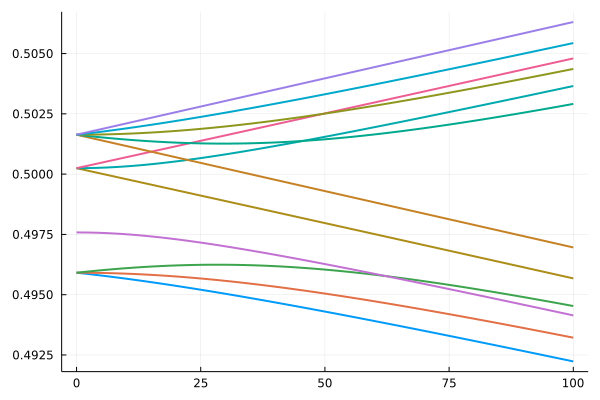

In [8]:
plot(Blist,eigsysX[5:16,:].E', legend=false, lw=2)

#### Grouping states

There is a set of functions to analyze the eigenstates in terms of useful quantum state labels. The function `subspaceinds` can be called to build a dictionary of eigenstates grouped according to selected quantum numbers. To use this, we pass in a list of `Eigenstate` and a "conditions" function that determines how to label the keys of the dictionary. Here's an example that groups the eigensystem by the zero-field quantum numbers N, J, and F.

In [9]:
function conditionsX(eigsys)
    evecs = eigsys[1].coeffs # pick out B=0 values
    basis = eigsys[1].basis # pick out B=0 values
    Nlab = basis[argmax(abs2.(evecs))].N
    Jlab = basis[argmax(abs2.(evecs))].J
    Flab = basis[argmax(abs2.(evecs))].F 
    label = (Nlab, Jlab, Flab)
    return label
end

XindsDict = subspaceinds(eigsysX, conditionsX)
;
XindsDict[1,1/2,0]


1-element Vector{Int64}:
 8

The dictionary provides easy access to the eigenstates satisfying the conditions associated with its keys. For example, let's look at the hyperfine intervals in the X state.

In [10]:
XindsDict[1,3/2,2]

5-element Vector{Int64}:
 12
 13
 14
 15
 16

In [11]:
e1 = eigsysX[XindsDict[1,1/2,1]].E*sol/1e4 |> mean
e2 = eigsysX[XindsDict[1,1/2,0]].E*sol/1e4 |> mean
e3 = eigsysX[XindsDict[1,3/2,1]].E*sol/1e4 |> mean
e4 = eigsysX[XindsDict[1,3/2,2]].E*sol/1e4 |> mean

println(e2-e1 |> abs)
println(e2-e3 |> abs)
println(e4-e3 |> abs)


50.09276104759738
79.88249609218656
41.60432330910044


In [12]:
meanE = mean([e1,e1,e1,e2,e3,e3,e3,e3,e4,e4,e4,e4,e4])
for e in [e1,e2,e3,e4]
    println(e-meanE)
end


-109.83782245009024
-59.745061402492865
20.13743468969369
61.74175799879413


In [13]:
eigsysX[XindsDict[3,5/2,3],1][1]

E = 2.991162
0.9776 |Λ = 0.0, N = 3.0, S = 0.5, J = 2.5, I = 0.5, F = 3.0, M = 3.0>
-0.2107 |Λ = 0.0, N = 3.0, S = 0.5, J = 3.5, I = 0.5, F = 3.0, M = 3.0>


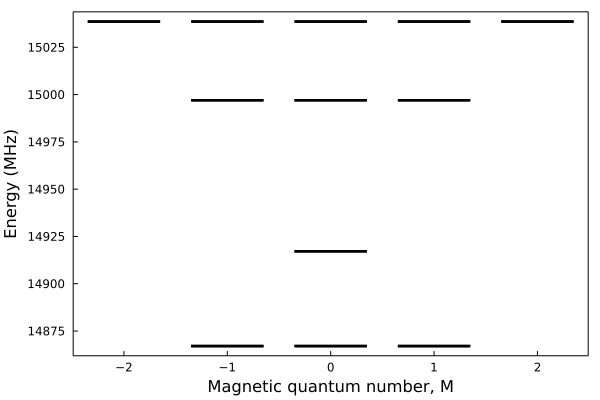

In [16]:
plotZeemanlevels(eigsysX[5:16,1])

We have a method `changebasis(eigensystem, newbasis)` to change the basis of a StructArray of `Eigenstate` objects. Note that when we do this we may have a different number of eigenvectors and basis states (limited by whichever basis set is smaller). 

In [15]:
eigsysX_casea = changebasis(eigsysX, basisX)
println(eigsysX_casea |> size)
println(eigsysX_casea[1,1].basis |> size)


(64, 100)
(80,)
